In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
!pip install plotly
!pip install mplcursors
import mplcursors
from matplotlib.ticker import FuncFormatter
import numpy as np 
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator
bond_price = pd.read_csv('data/BondPrice.csv')
bond_quant = pd.read_csv('data/BondQuant.csv') 



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
path='data/BondPrice.csv'
bprice=pd.read_csv(path)
msPrice=bprice[bprice["L1 ID"]==20059]
cleanMsPrice = msPrice.dropna(axis=1) 
print(cleanMsPrice)

    L1 ID   Series
61  20059  Average


In [4]:
def melt_clean_price(df):
    # Drop columns with NaN 
    clean_df = df.dropna(axis=1) 
    df_melted = clean_df.melt(var_name='Timestamp', value_name='Price')
    df_melted = df_melted.iloc[2:].reset_index(drop=True)
    return df_melted

# Graph for price function
def graph_price(df, title):
    # convert timestamp dtype into datetime dtype
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    # Set up Seaborn plot
    fig, ax = plt.subplots(figsize=(10, 6))
    scatplot = sns.scatterplot(data=df, x='Timestamp', y='Price', marker='o')
    #scatplot.axvspan(xmin=pd.Timestamp("1819"), xmax=pd.Timestamp("1822"), fc="#E0837F")
    # Format x-axis ticks to show year 
    date_form = DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gca().xaxis.set_major_locator(YearLocator())
    # Get the minimum and maximum dates with data (assuming 'date' is a datetime type)
    min_date = df['Timestamp'].min()
    max_date = df['Timestamp'].max()
    # Set the x-axis limits to exclude extra years
    plt.xlim(min_date, max_date)

    # Enhance plot aesthetics (optional)
    plt.xlabel('Year')
    plt.ylabel('Market Price (Dollars)')
    plt.title(title)
    plt.grid(True)

    # Add hovering features 
    def show_hover_panel(get_text_func=None):
        cursor = mplcursors.cursor(
            scatplot, 
            hover=2,  # Transient
            annotation_kwargs=dict(
                bbox=dict(
                    boxstyle="square,pad=0.5",
                    facecolor="white",
                    edgecolor="#ddd",
                    linewidth=0.5,
                    path_effects=[pe.withSimplePatchShadow(offset=(1.5, -1.5))],
                ),
                linespacing=1.5,
                arrowprops=None,
            ),
            highlight=True,
            highlight_kwargs=dict(linewidth=2),
        )
    
        if get_text_func:
            cursor.connect(
                event="add",
                func=lambda sel: sel.annotation.set_text(get_text_func(df, sel.index)),
            )
    
        return cursor
    
    
    def on_add(df, index):
        item = df.iloc[index]
        parts = [
            f"Date: {item.Timestamp.strftime('%Y-%m-%d')}",
            f"Price: {item.Price:,.2f}",
        ]
    
        return "\n".join(parts)

    show_hover_panel(on_add) # add cursor hover features 

    plt.plot(df['Timestamp'], df['Price'])
    
    return plt # return completed figure 

In [5]:
# clean quant dataframe 
# returns a series with chosen row 
def clean_quant(quant_df):
    subset_cols = quant_df.columns[2:] 
    # Drop rows where all columns are Nan 
    temp_clean_quant_df = quant_df.dropna(how="all", subset=subset_cols).dropna(axis=1)
    # print(clean_six_percent_prices)
    # print(temp_clean_six_percent_quant)
    
    # Define the threshold
    threshold = 0.001
    # Function to check if all values in a column are close to zero
    def is_close_to_zero(col, threshold):
        return np.all(np.abs(col) < threshold)
    
    cols_to_drop = [col for col in temp_clean_quant_df.iloc[:, 2:].columns if is_close_to_zero(temp_clean_quant_df[col], threshold)]
    
    # Drop the columns
    clean_quant_df = temp_clean_quant_df.drop(columns=cols_to_drop)
    return clean_quant_df
    # print(clean_quant_df) 

def reformat_quant(clean_quant_df, row):
    # reformat dataframe to include timestamp and quant columns 
    series_data = clean_quant_df[clean_quant_df["Series"] == row].melt(var_name='Timestamp', value_name='Quant')
    series_data = series_data.iloc[2:].reset_index(drop=True)
    series_data['Timestamp'] = pd.to_datetime(series_data['Timestamp']) #convert timestamp column to a datetime object 
    return series_data # return the selected row 

# graphing function
def graph_quant(df, title, axis):
    # Set up Seaborn plot
    fig, ax = plt.subplots(figsize=(10, 6))
    # lineplot = sns.lineplot(data=df, x="Timestamp", y="Quant") 
    scatplot = sns.scatterplot(data=df, x='Timestamp', y='Quant', marker='o')
    #scatplot.axvspan(xmin=pd.Timestamp("1819"), xmax=pd.Timestamp("1822"), fc="#E0837F")
    # Format x-axis ticks to show year 
    date_form = DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gca().xaxis.set_major_locator(YearLocator(2))
    # Get the minimum and maximum dates with data (assuming 'date' is a datetime type)
    min_date = df['Timestamp'].min()
    max_date = df['Timestamp'].max()
    # Set the x-axis limits to exclude extra years
    plt.xlim(min_date, max_date)

    # reformat y-axis to be in millions, not tens of millions
    if axis == "mil":
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e6)))
        plt.ylabel('Total Outstanding (millions)')
    elif axis == "ht": 
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x / 1e5)))
        plt.ylabel('Total Outstanding (hundred thousands)')

    # Enhance plot aesthetics (optional)
    plt.xlabel('Year')
    plt.title(title)
    plt.grid(True)

        # Add hovering features 
    def show_hover_panel(get_text_func=None):
        cursor = mplcursors.cursor(
            scatplot, 
            hover=2,  # Transient
            annotation_kwargs=dict(
                bbox=dict(
                    boxstyle="square,pad=0.5",
                    facecolor="white",
                    edgecolor="#ddd",
                    linewidth=0.5,
                    path_effects=[pe.withSimplePatchShadow(offset=(1.5, -1.5))],
                ),
                linespacing=1.5,
                arrowprops=None,
            ),
            highlight=True,
            highlight_kwargs=dict(linewidth=2),
        )
    
        if get_text_func:
            cursor.connect(
                event="add",
                func=lambda sel: sel.annotation.set_text(get_text_func(df, sel.index)),
            )
    
        return cursor
    
    
    def on_add(df, index):
        item = df.iloc[index]
        parts = [
            f"Date: {item.Timestamp.strftime('%Y-%m-%d')}",
            f"Quant: {item.Quant:,.2f}",
        ]
    
        return "\n".join(parts)

    show_hover_panel(on_add) # add cursor hover features 
    
    plt.plot(df['Timestamp'], df['Quant'])
    return plt

# Add a historical marker
# An important event 
def add_marker(axis, event_str, date, price):
    axis.annotate(event_str,
            xy=(pd.Timestamp(date), price), xycoords='data',
            xytext=(30, 10), textcoords='offset points', size=8, 
            arrowprops=dict(facecolor='black', shrink=0.05))

# color background to define a period
def add_period(plot, begin, end):
    # ax.text(pd.Timestamp("1820-06"), 90, 'Panic of 1819', horizontalalignment='center')
    plot.axvspan(xmin=pd.Timestamp(begin), xmax=pd.Timestamp(end), fc="#E0837F")

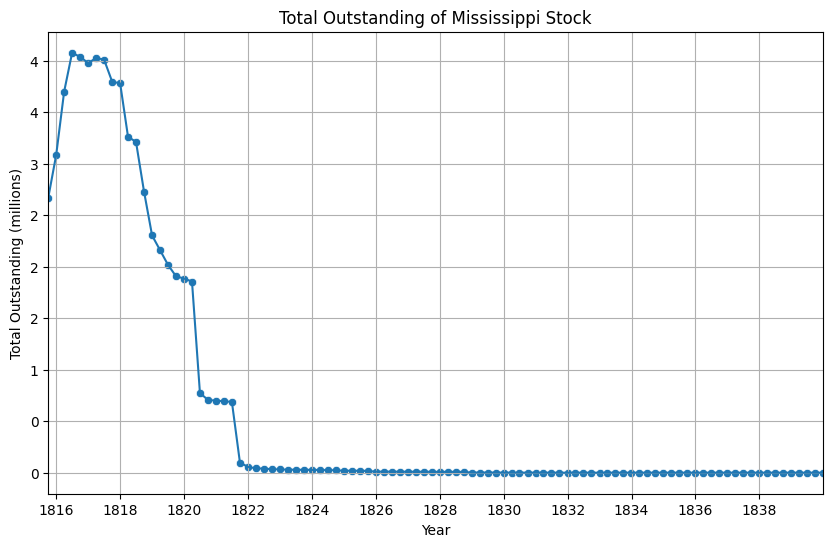

In [6]:
Ms_Stock_quant = bond_quant[bond_quant["L1 ID"] == 20059]
clean_Ms_Stock_quant = clean_quant(Ms_Stock_quant)
total_outstanding = reformat_quant(clean_Ms_Stock_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Mississippi Stock", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_Ms_Stock_quant, "Public Holdings")

Mississippi Stock: Non-interest bearing stock paid to companies and individual claimants, worth $4,282,030.92.


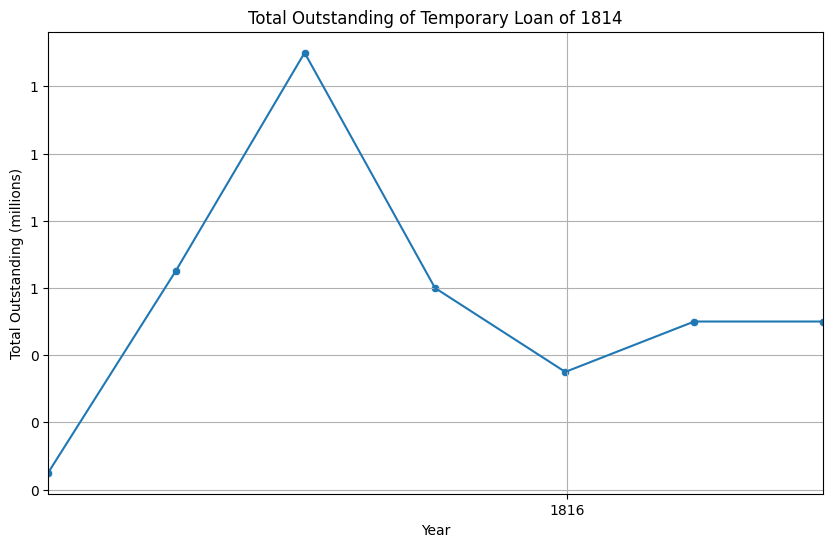

In [7]:
temp_loan_1814_quant=bond_quant[bond_quant["L1 ID"]==20060]
clean_temp_loan_1814_quant=clean_quant(temp_loan_1814_quant)
total_outstanding = reformat_quant(clean_temp_loan_1814_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Temporary Loan of 1814", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_temp_loan_1814_quant, "Public Holdings") 

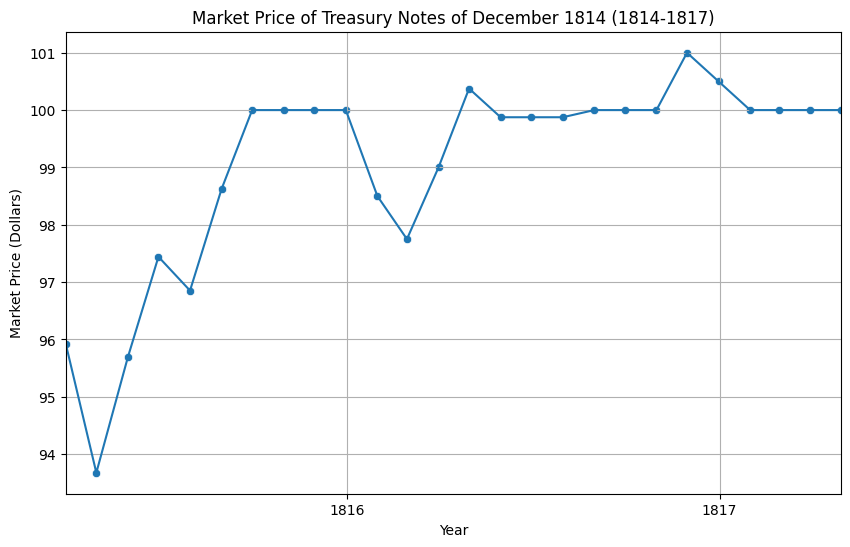

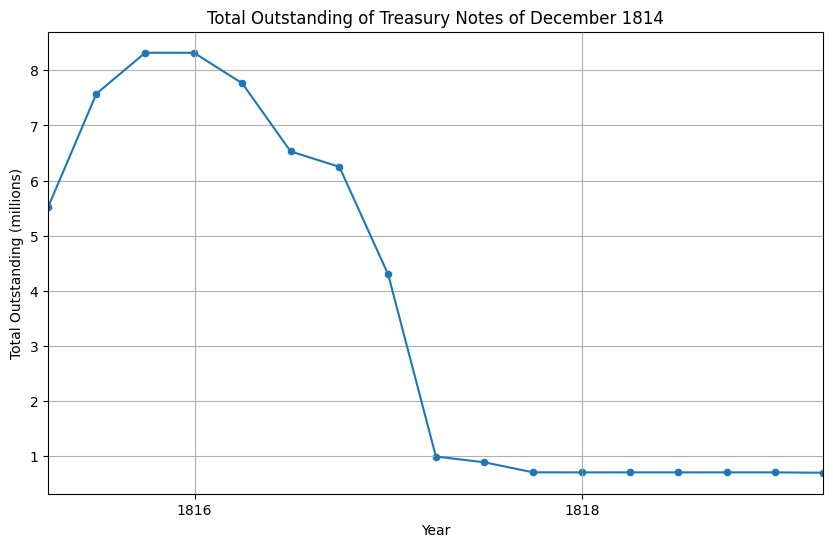

In [8]:
treasure_notes_prices = bond_price[bond_price["L1 ID"] == 20061] 
treasure_notes_melted = melt_clean_price(treasure_notes_prices) # clean and melt (reformat) dataframe 
treasure_notes = graph_price(treasure_notes_melted, 'Market Price of Treasury Notes of December 1814 (1814-1817)')
treasure_notes.show()

treasure_notes_quant=bond_quant[bond_quant["L1 ID"]==20061]
clean_treasure_notes_quant=clean_quant(treasure_notes_quant)
total_outstanding = reformat_quant(clean_treasure_notes_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Treasury Notes of December 1814", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_treasure_notes_quant, "Public Holdings") 

Direct Tax Loan

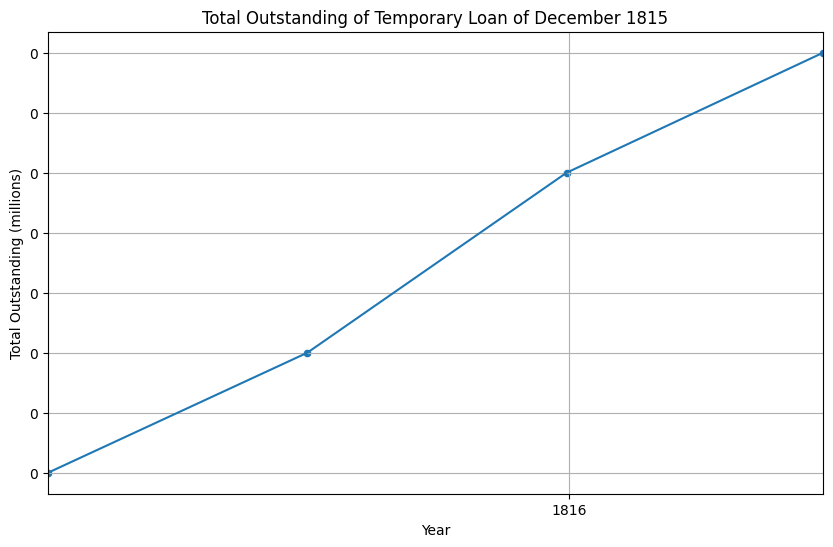

In [9]:
feb_temp_loan_quant=bond_quant[bond_quant["L1 ID"]==20063]
clean_feb_temp_loan_quant=clean_quant(feb_temp_loan_quant)
total_outstanding = reformat_quant(clean_feb_temp_loan_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Temporary Loan of December 1815", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_feb_temp_loan_quant, "Public Holdings") 

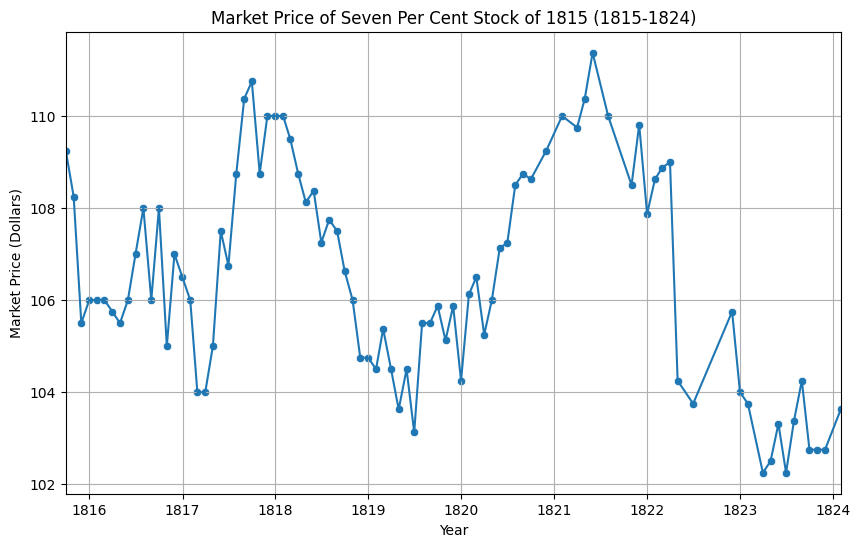

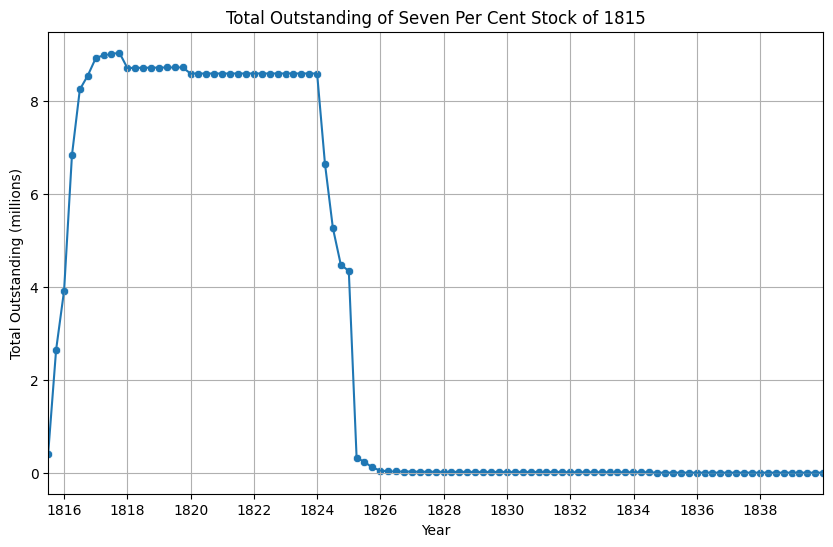

In [10]:
Seven_Per_Cent_prices = bond_price[bond_price["L1 ID"] == 20064] 
Seven_Per_Cent_melted = melt_clean_price(Seven_Per_Cent_prices) # clean and melt (reformat) dataframe 
Seven_Per_Cent = graph_price(Seven_Per_Cent_melted, 'Market Price of Seven Per Cent Stock of 1815 (1815-1824)')
Seven_Per_Cent.show()

Seven_Per_Cent_quant=bond_quant[bond_quant["L1 ID"]==20064]
clean_Seven_Per_Cent_quant=clean_quant(Seven_Per_Cent_quant)
total_outstanding = reformat_quant(clean_Seven_Per_Cent_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Seven Per Cent Stock of 1815", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_Seven_Per_Cent_quant, "Public Holdings") 

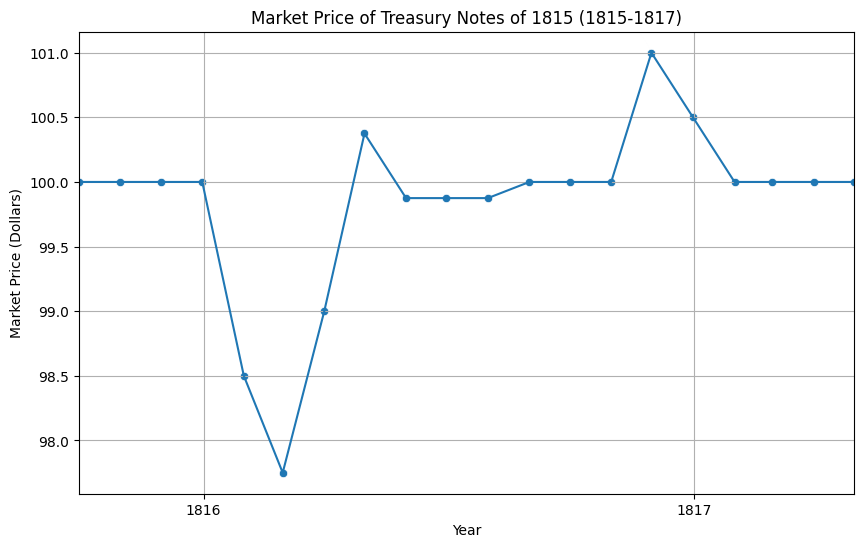

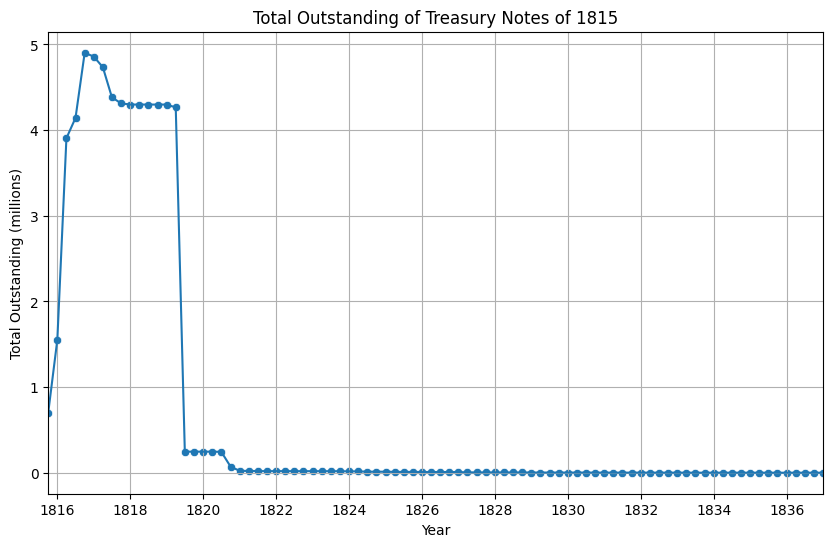

In [11]:
treasure_notes_1815_prices = bond_price[bond_price["L1 ID"] == 20065] 
treasure_notes_1815_melted = melt_clean_price(treasure_notes_1815_prices) # clean and melt (reformat) dataframe 
treasure_notes_1815 = graph_price(treasure_notes_1815_melted, 'Market Price of Treasury Notes of 1815 (1815-1817)')
treasure_notes_1815.show()

treasure_notes_1815_quant=bond_quant[bond_quant["L1 ID"]==20065]
clean_treasure_notes_1815_quant=clean_quant(treasure_notes_1815_quant)
total_outstanding = reformat_quant(clean_treasure_notes_1815_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Treasury Notes of 1815", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_treasure_notes_1815_quant, "Public Holdings") 

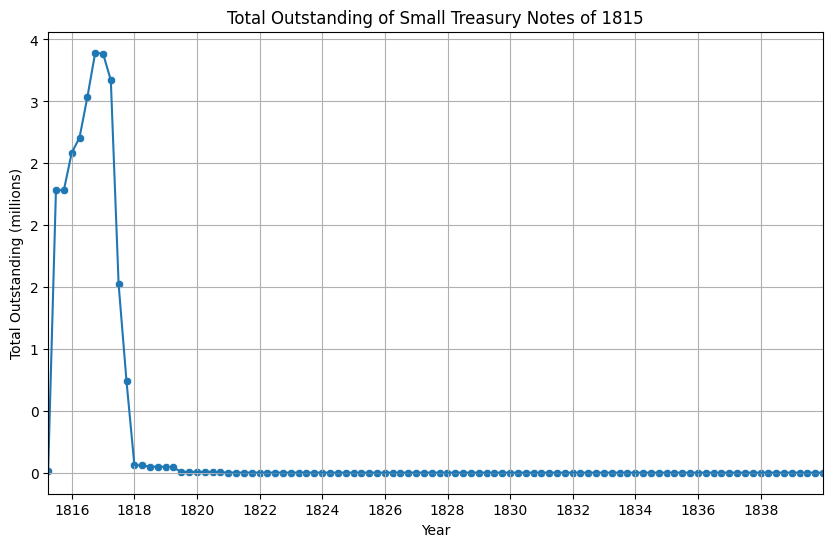

In [12]:
small_treasure_notes_quant=bond_quant[bond_quant["L1 ID"]==20066]
clean_small_treasure_notes_quant=clean_quant(small_treasure_notes_quant)
total_outstanding = reformat_quant(clean_small_treasure_notes_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of Small Treasury Notes of 1815", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_small_treasure_notes_quant, "Public Holdings") 

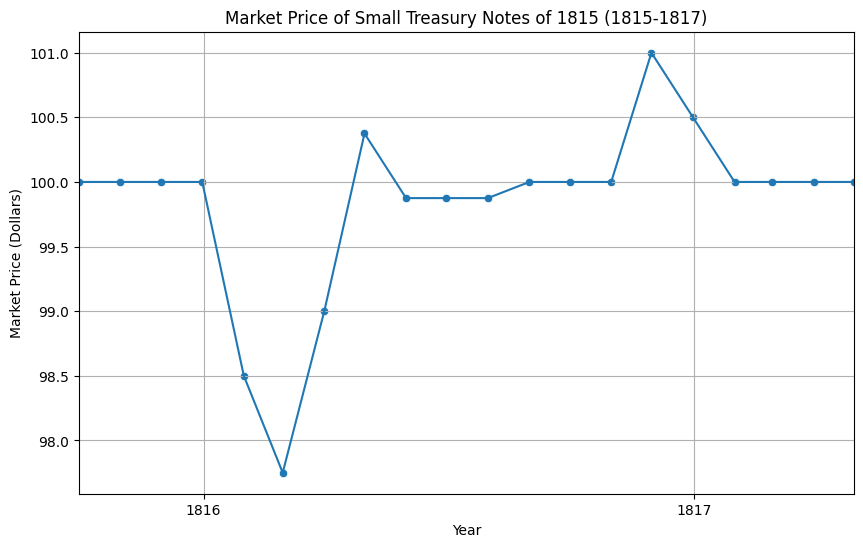

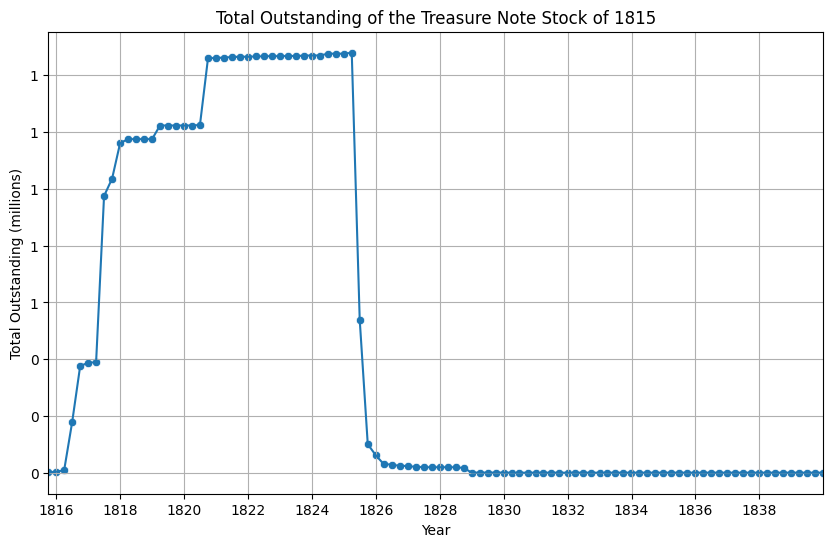

In [13]:
treasure_note_stock_prices = bond_price[bond_price["L1 ID"] == 20067] 
treasure_note_stock_melted = melt_clean_price(treasure_note_stock_prices)
treasure_note_stock = graph_price(treasure_note_stock_melted, 'Market Price of Small Treasury Notes of 1815 (1815-1817)')
treasure_note_stock.show()

treasure_note_stock_quant=bond_quant[bond_quant["L1 ID"]==20067]
clean_treasure_note_stock_quant=clean_quant(treasure_note_stock_quant)
total_outstanding = reformat_quant(clean_treasure_note_stock_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of the Treasure Note Stock of 1815", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_small_treasure_notes_quant, "Public Holdings") 

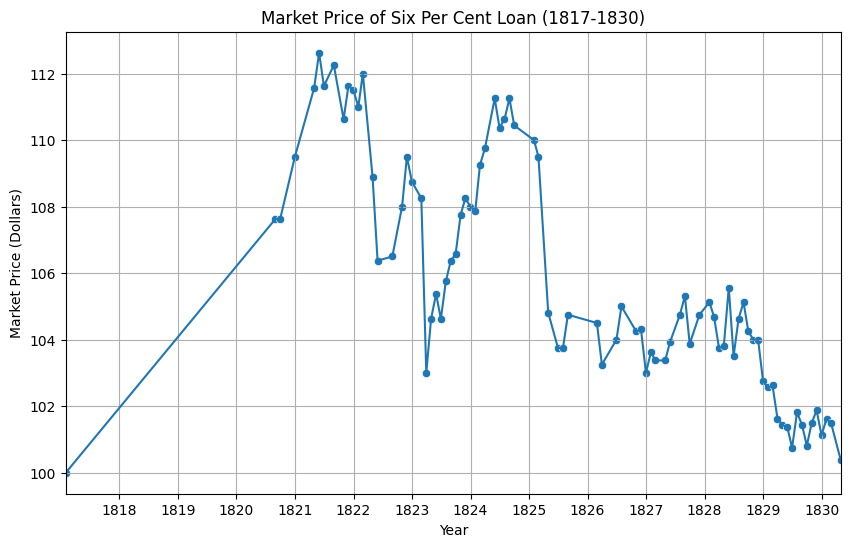

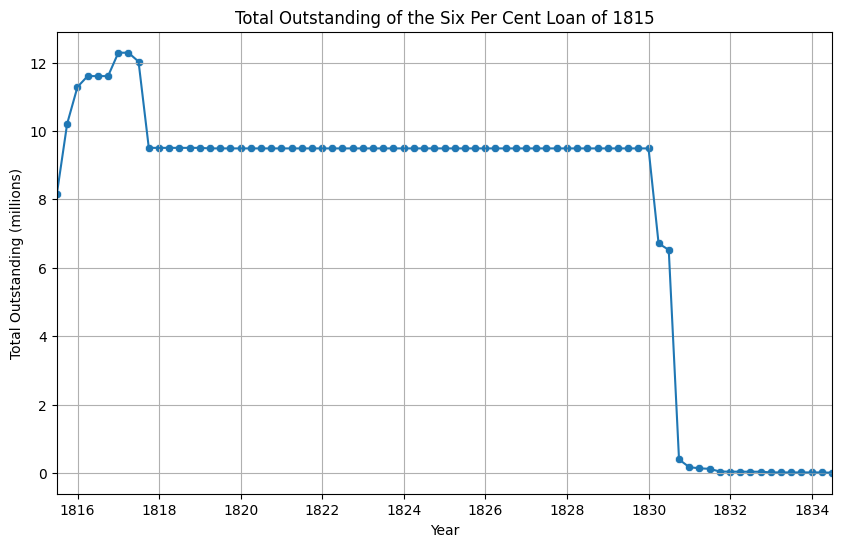

In [14]:
six_per_cent_loan_prices = bond_price[bond_price["L1 ID"] == 20069] 
six_per_cent_loan_melted = melt_clean_price(six_per_cent_loan_prices)
six_per_cent_loan = graph_price(six_per_cent_loan_melted, 'Market Price of Six Per Cent Loan (1817-1830)')
six_per_cent_loan.show()

six_per_cent_loan_quant=bond_quant[bond_quant["L1 ID"]==20069]
clean_six_per_cent_loan_quant=clean_quant(six_per_cent_loan_quant)
total_outstanding = reformat_quant(clean_six_per_cent_loan_quant, "Total Outstanding")
total_outstanding_plot = graph_quant(total_outstanding, "Total Outstanding of the Six Per Cent Loan of 1815", "mil") 
total_outstanding_plot.show()
public_holdings = reformat_quant(clean_six_per_cent_loan_quant, "Public Holdings") 